In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False 

import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Algorithms

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation 
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
import os 
os.listdir('../../data/modelling_data/')

['.DS_Store', 'model_data_연속형행동.csv', 'model_data_이항형행동.csv']

In [3]:
from sklearn.model_selection import train_test_split

def split_data(data):
    
    data =  data[(data.Y1 == 1) & (data.Mapping.notna())]
    x_col =  ['quantile', 'Title_C-Level',
       'Title_Manager', 'Title_Team Leader', 'Title_etc', 'Industry_산업_IT서비스',
       'Industry_산업_others', 'Industry_산업_금융', 'Industry_산업_일반서비스',
       'Industry_산업_제조', 'isfam_1.0', 'first_action_1', '고객등급_1', '고객등급_2',
       '고객등급_3', '고객등급_4', '고객등급_5', '고객등급_6', '고객등급_7','webvisit', 'EmailClickthrough',
       'EmailOpen', 'register', 'subscribe', 'download', 'survey','event',  'service_request', 'attend']

    X = data[x_col]; y = data.Y2
   
    return X, y
    
def get_settings():
    #Classifiers
    clf1 = RandomForestClassifier(random_state=123)
    clf2 = XGBClassifier(random_state=123, use_label_encoder =False)

    #Random Forest 
    param_grid1 = [{'max_depth': [5, 10, 20, 30, None],
                    'min_samples_leaf': [1,2,4],
                   'min_samples_split': [2, 3, None], 
                    'n_estimators': [100, 200, 400, 1000]}] 

    # XGBClassifier
    param_grid2 = [{'n_estimators': [500, 1000, 2000],
                    'learning_rate': [0.01, 0.05, 0.1, 1],
                    'max_depth': [None, 6, 9, 12]}]
    
    return clf1,clf2, param_grid1, param_grid2

def CV10_model_selection(X_train, y_train, clf1, clf2, param_grid1, param_grid2):
    # 10 fold CV 
    # Algorithm Selection 
    print('\n10-CV')
    results = []
    for name, clf, param_grid in zip(('Random Forest', 'XGBoost'),(clf1,  clf2),(param_grid1, param_grid2)):
        gcv_model_select_i = GridSearchCV(estimator=clf,
                                          param_grid=param_grid,
                                          scoring='accuracy',
                                          n_jobs= -1,
                                          cv =10,
                                          verbose=1,
                                          refit=True)
        gcv_model_select_i.fit(X_train, y_train)
        results.append(gcv_model_select_i)
        print('- ',name)
        print('Best CV accuracy: %.2f%%' % (gcv_model_select_i.best_score_*100),', \nBest parameters:', gcv_model_select_i.best_params_ )
    return results

def CV5_score(results, X_train, y_train):
    classifiers = [results[0].best_estimator_ , results[1].best_estimator_ ]
    names = ['Random Forests', 'XGBoost']
    evaluations = {}
    print('\n5-Cross Validate Score')
    for clf, name in zip(classifiers, names):

        evaluations[name] = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
        for score in ['accuracy', 'precision', 'recall', 'f1']:
            scores = cross_validate(clf, X_train, y_train, scoring=score,
                                 cv=5, return_train_score= False)
            evaluations[name][score] = scores


    for name in names: 
        result = evaluations[name]
        acc = result['accuracy']['test_score'].mean()
        precision = result['precision']['test_score'].mean()
        recall = result['recall']['test_score'].mean()
        f1 = result['f1']['test_score'].mean()
        print('- ',name)
        print('      Mean Accuracy:', round(acc,4))
        print('      Mean Precision:', round(precision,4))
        print('      Mean Recall:', round(recall,4))
        print('      Mean f1:', round(f1,4))
    return evaluations

def fit_evaluate(results, X_train, y_train, X_test, y_test):
    #Fit on training & Evaluating on test set 
    classifiers = [results[0].best_estimator_ , results[1].best_estimator_ ]
    names = ['Random Forests', 'XGBoost']
    print('\nEvaluation on Test Set')
    
    for clf, name in zip(classifiers, names):
        best_model = clf
        best_model.fit(X_train, y_train)

        prediction = best_model.predict(X_test)

        train_acc = round(accuracy_score(y_train, best_model.predict(X_train)),4)
        test_acc = round(accuracy_score(y_test, prediction),4)

        precision =  round(precision_score(y_test, prediction), 4)
        recall = round(recall_score(y_test, prediction), 4)
        f1 = round(2*recall*precision/(recall+precision),4)
        auc = round(roc_auc_score(y_test, prediction),4)
        print(' - ',name)
        print('      Train Accuracy: %.2f%%' % (100 * train_acc))
        print('      Test Accuracy: %.2f%%' % (100 * test_acc))

        print('      Precision: ',precision)
        print('      Recall: ', recall)
        print('      AUC: ', auc)
        print('      f1: ', f1)

        matrix = np.array(confusion_matrix(y_test, prediction))
        #con_mat_norm = np.around(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], decimals=2)
        con_mat_df = pd.DataFrame(matrix)
        #con_norm_df = pd.DataFrame(con_mat_norm)

        figure = plt.figure(figsize=(5, 5))

        sns.heatmap(con_mat_df, annot=True,fmt='d',cmap=plt.cm.Blues)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix (count)')
        plt.show()


In [4]:
model_data_path = '../../data/modelling_data/'

def train_model(model_data_path, option = 'binary'):
    if option == 'continuous':
        data = pd.read_csv(model_data_path + 'model_data_연속형행동.csv')
    else:
        data =  pd.read_csv(model_data_path + 'model_data_이항형행동.csv')
    X, y = split_data(data)
    X_train, X_test, y_train, y_test =  train_test_split(X, y,  
                                                         test_size = 0.25,
                                                         stratify = y, 
                                                         random_state=123) # train_test_split 함수 사용 
    clf1,clf2, param_grid1, param_grid2 = get_settings()
    results = CV10_model_selection(X_train, y_train, clf1, clf2, param_grid1, param_grid2)
    evaluations = CV5_score(results, X_train, y_train)
    fit_evaluate(results, X_train, y_train, X_test, y_test)
    return results, evaluations
    
    


10-CV
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
-  Random Forest
Best CV accuracy: 98.44% , 
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 10 folds for each of 48 candidates, totalling 480 fits
-  XGBoost
Best CV accuracy: 98.51% , 
Best parameters: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 1000}

5-Cross Validate Score
-  Random Forests
      Mean Accuracy: 0.9845
      Mean Precision: 1.0
      Mean Recall: 0.4262
      Mean f1: 0.5967
-  XGBoost
      Mean Accuracy: 0.9849
      Mean Precision: 0.9845
      Mean Recall: 0.4462
      Mean f1: 0.6136

Evaluation on Test Set
 -  Random Forests
      Train Accuracy: 98.50%
      Test Accuracy: 98.05%
      Precision:  1.0
      Recall:  0.2727
      AUC:  0.6364
      f1:  0.4285


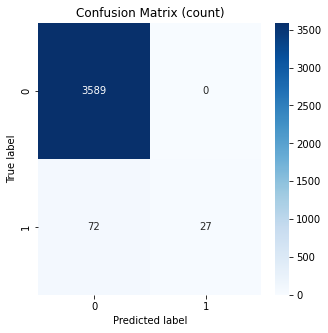

 -  XGBoost
      Train Accuracy: 98.58%
      Test Accuracy: 98.10%
      Precision:  1.0
      Recall:  0.2929
      AUC:  0.6465
      f1:  0.4531


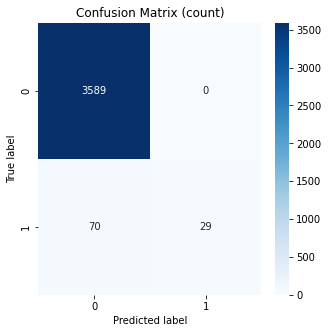

In [5]:
binary_result, binary_cv5_result = train_model(model_data_path, option = 'binary')


10-CV
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
-  Random Forest
Best CV accuracy: 98.47% , 
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Fitting 10 folds for each of 48 candidates, totalling 480 fits
-  XGBoost
Best CV accuracy: 98.54% , 
Best parameters: {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 500}

5-Cross Validate Score
-  Random Forests
      Mean Accuracy: 0.9848
      Mean Precision: 1.0
      Mean Recall: 0.4362
      Mean f1: 0.6065
-  XGBoost
      Mean Accuracy: 0.9846
      Mean Precision: 0.9345
      Mean Recall: 0.4631
      Mean f1: 0.6178

Evaluation on Test Set
 -  Random Forests
      Train Accuracy: 99.25%
      Test Accuracy: 98.02%
      Precision:  0.9333
      Recall:  0.2828
      AUC:  0.6411
      f1:  0.4341


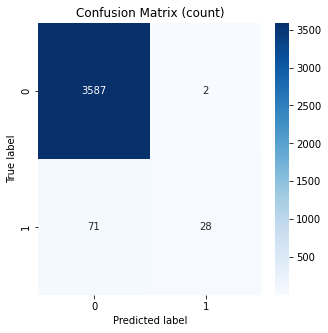

 -  XGBoost
      Train Accuracy: 99.14%
      Test Accuracy: 98.05%
      Precision:  0.8857
      Recall:  0.3131
      AUC:  0.656
      f1:  0.4627


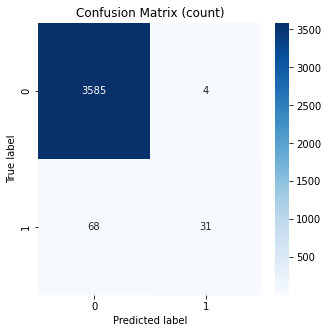

In [6]:
continuous_result, continuous_cv5_result = train_model(model_data_path, option = 'continuous')

In [7]:

# def compare_f1_accuracy(results, X_train, y_train):
#     rf = results[0].best_estimator_ 
#     xg = results[1].best_estimator_

#     print('\nRandom Forest \n  ',rf , '\nXGBoost \n.  ',xg)
#     cv5_f1 = []; cv5_acc = []
#     for model in [rf, xg]:
#         cv_acc =cross_val_score(model, # 지정해주기 
#                                 X = X_train, y = y_train,
#                                 scoring="f1",cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
#                                 n_jobs=2)
#         cv_acc2 =cross_val_score(model, # 지정해주기 
#                                  X = X_train, y = y_train,
#                               cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
#                               n_jobs=2)
#         print('Mean F1: %.2f%%' % (np.mean(cv_acc)*100))
#         print('Mean Acc: %.2f%%' % (np.mean(cv_acc2)*100))
#         cv5_f1.append(np.mean(cv_acc))
#         cv5_acc.append(np.mean(cv_acc2))
        
#         cv_res = [np.mean(cv5_result[0]), np.mean(cv5_result[1])]
#         idx = pd.Series(cv_res).fillna(0).idxmax()
#         best_model = [rf,xg][idx]
#         print(best_model)
#     return best_model
